<a href="https://colab.research.google.com/github/yutao-data/Sepsis_Gene_KnowledgeGraph_Ontology/blob/main/Sepsis_Dataset_Exploring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gprofiler
!pip install GEOparse
!pip install owlready2
!pip install gprofiler-official

In [2]:
import requests
from gprofiler import GProfiler
import GEOparse
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind
from owlready2 import *
import warnings
from itertools import combinations
from io import StringIO
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Data

In [4]:
warnings.filterwarnings("ignore")

onto = get_ontology("http://purl.obolibrary.org/obo/go.owl").load()
ppio_ontology = get_ontology("/content/drive/MyDrive/stagelisn2024-main/PPI_Onto.owl").load()
onto.imported_ontologies.append(ppio_ontology)

In [5]:
# Load GPL annotations
gpl_annotations = pd.read_csv("/content/drive/MyDrive/stagelisn2024-main/data/GPL6947-13512.txt", sep="\t", comment='#')

# Map probes to gene IDs
probe_to_gene = gpl_annotations[['ID', 'Entrez_Gene_ID']]
probe_to_gene = probe_to_gene.dropna(subset=['Entrez_Gene_ID'])
probe_to_gene['Entrez_Gene_ID'] = probe_to_gene['Entrez_Gene_ID'].astype(int)

probe_to_gene.head()

,ID,Entrez_Gene_ID
0,ILMN_1725881,23117
2,ILMN_1804174,2213
3,ILMN_1796063,54765
4,ILMN_1811966,653895
5,ILMN_1668162,158833


In [6]:
# Load GEO dataset
gse = GEOparse.get_GEO(filepath="/content/drive/MyDrive/stagelisn2024-main/data/GSE54514_family.soft.gz", silent=True)

expression_data = pd.DataFrame()
for gsm_name, gsm in gse.gsms.items():
    expression_data[gsm_name] = gsm.table.set_index("ID_REF")["VALUE"]

expression_data = expression_data.T
expression_data = expression_data.apply(pd.to_numeric, errors='coerce')
expression_data.dropna(axis=1, inplace=True)

expression_data.head()

ID_REF,ILMN_2055271,ILMN_2383229,ILMN_1806310,ILMN_1653355,ILMN_2359168,ILMN_1735045,ILMN_1680754,ILMN_1755321,ILMN_1698554,ILMN_1814092,...,ILMN_1673117,ILMN_1685547,ILMN_2348512,ILMN_1743643,ILMN_1656676,ILMN_2371169,ILMN_1701875,ILMN_1786396,ILMN_1653618,ILMN_2137536
GSM1317896,7.478478,7.732890,7.346000,7.541464,7.080655,7.190928,7.043338,7.282018,7.467964,7.253072,...,7.544874,7.085921,7.725375,7.403544,9.052076,10.826351,11.510887,7.748866,7.265069,7.520050
GSM1317897,7.194329,7.091616,7.127377,7.139050,7.076957,7.101918,7.574589,7.151289,7.164247,7.159713,...,7.302628,7.336513,7.182846,7.689322,10.352952,11.409938,12.015053,7.996690,7.173827,7.241760
GSM1317898,7.118431,7.008995,7.147905,7.251543,7.031998,7.064355,7.070183,7.306010,7.277900,7.067508,...,7.048484,7.122465,7.274913,7.498920,9.439990,10.910384,11.717704,8.072896,7.261295,7.426808
GSM1317899,7.286120,7.122940,7.106208,7.241961,7.050389,7.096496,7.110168,7.278481,7.289622,7.224060,...,7.055483,7.104158,7.215575,7.570657,9.394814,10.858485,12.152800,7.796620,7.399535,7.567951
GSM1317900,7.225378,7.035687,7.268438,7.289307,7.099056,7.138676,7.375244,7.279981,7.543007,7.231372,...,7.086588,7.223078,7.218124,7.576488,9.480348,11.233749,12.124186,7.987269,7.235961,7.218149


In [7]:
sample_status = [gsm.metadata["characteristics_ch1"][1].split(": ")[1] for gsm in gse.gsms.values()]

sample_info = pd.DataFrame({"Sample": expression_data.index, "Status": sample_status})

group1 = sample_info[sample_info["Status"] == "healthy"]["Sample"]
group2 = sample_info[sample_info["Status"] != "healthy"]["Sample"]

sample_info.head()

,Sample,Status
0,GSM1317896,healthy
1,GSM1317897,healthy
2,GSM1317898,healthy
3,GSM1317899,healthy
4,GSM1317900,healthy


## P Values & Co-Expression_edges

In [8]:
p_values = np.array([ttest_ind(expression_data.loc[group1, gene],
                               expression_data.loc[group2, gene])[1]
                     for gene in expression_data.columns])

_, p_adjusted, _, _ = multipletests(p_values, method='fdr_bh')

degs = expression_data.columns[p_adjusted < 0.01]

degs_symbols = probe_to_gene[probe_to_gene['ID'].isin(degs)]
degs_symbols = degs_symbols.drop_duplicates(subset=['Entrez_Gene_ID'])

selected_genes = degs_symbols['Entrez_Gene_ID'].astype(str).tolist()
selected_probes = degs_symbols[degs_symbols['Entrez_Gene_ID'].astype(str).isin(selected_genes)]['ID']

print("selected_genes is", selected_genes[:5])
print("selected_probes is \n", selected_probes[:5])

selected_genes is ['5830', '10844', '84280', '9361', '581']
selected_probes is 
 36     ILMN_1660232
50     ILMN_1775074
56     ILMN_1809344
66     ILMN_1766125
109    ILMN_2321064
Name: ID, dtype: object


In [9]:
# Create a dictionary mapping probe IDs to Entrez Gene IDs
probe_to_entrez = dict(zip(probe_to_gene['ID'], probe_to_gene['Entrez_Gene_ID'].astype(str)))

# Subset expression data for selected probes
expression_degs = expression_data[selected_probes]

correlation_matrix = expression_degs.corr(method='spearman')

# Identify co-expressed gene pairs based on correlation threshold 0.8
co_expression_edges = []
threshold = 0.8
for probe1 in correlation_matrix.columns:
    for probe2 in correlation_matrix.columns:
        if probe1 != probe2 and correlation_matrix.loc[probe1, probe2] > threshold:
            gene1 = probe_to_entrez[probe1]
            gene2 = probe_to_entrez[probe2]
            co_expression_edges.append((gene1, gene2))

print(f"Number of co-expressed gene pairs found: {len(co_expression_edges)}")

co_expression_edges[:5]

Number of co-expressed gene pairs found: 768


[('84280', '25801'),
 ('84280', '11275'),
 ('84280', '4659'),
 ('84280', '51167'),
 ('641455', '402221')]

## Get GO and Protein Results

In [10]:
def get_go_annotations(gene_symbols):
    '''Function to get GO annotations
    @param list of entrez gene ID
    @return two df, one for the GO results and one for the expressed related proteins
    '''
    gp = GProfiler(return_dataframe=True)
    go_results = gp.profile(
        organism='hsapiens',
        query=gene_symbols,
        no_evidences=False,
        sources=["GO:CC", "GO:BP", 'GO:MF']
    )
    protein_results = gp.convert(
        organism='hsapiens',
        query=gene_symbols,
        target_namespace='PROTEIN_ID',
        numeric_namespace='ENTREZGENE_ACC'
    )
    return go_results, protein_results

In [11]:
gene_symbols = selected_genes

go_results, protein_results = get_go_annotations(gene_symbols)
go_results = go_results.drop_duplicates('native')

print("go_results is\n", go_results.head())

go_results is
   source      native                                name       p_value  \
0  GO:CC  GO:0005737                           cytoplasm  1.603973e-74   
1  GO:MF  GO:0005515                     protein binding  1.028236e-57   
2  GO:CC  GO:0005654                         nucleoplasm  2.593112e-48   
3  GO:CC  GO:0005829                             cytosol  9.104122e-45   
4  GO:CC  GO:0005622  intracellular anatomical structure  6.468287e-41   

   significant                                        description  term_size  \
0         True  "The contents of a cell excluding the plasma m...      12345   
1         True          "Binding to a protein." [GOC:go_curators]      14838   
2         True  "That part of the nuclear content other than t...       4220   
3         True  "The part of the cytoplasm that does not conta...       5487   
4         True  "A component of a cell contained within (but n...      17834   

   query_size  intersection_size  effective_domain_size  pr

In [12]:
protein_results = protein_results.drop_duplicates('incoming')
print("protein_results is\n", protein_results.head())

protein_results is
    incoming   converted  n_incoming  n_converted     name  \
0      5830  AAC50103.1           1            1     PEX5   
14    10844  AAC39728.1           2            1  TUBGCP2   
19    84280  AAH05071.2           3            1   BTBD10   
30     9361  AAA61616.1           4            1    LONP1   
78      581  AAA03619.1           5            1      BAX   

                                          description      namespaces    query  
0   peroxisomal biogenesis factor 5 [Source:HGNC S...  ENTREZGENE_ACC  query_1  
14  tubulin gamma complex associated protein 2 [So...  ENTREZGENE_ACC  query_1  
19  BTB domain containing 10 [Source:HGNC Symbol;A...  ENTREZGENE_ACC  query_1  
30  lon peptidase 1, mitochondrial [Source:HGNC Sy...  ENTREZGENE_ACC  query_1  
78  BCL2 associated X, apoptosis regulator [Source...  ENTREZGENE_ACC  query_1  


In [13]:
def get_biogrid_interactions(proteins, taxon_id=9606, api_key='2288556b908f441f022341112c9c9c08'):
    ''' Function to get BioGRID interactions, can be relatively slow
    @param list of proteins in their standard id (do not modify other parameters, taxon id being the specie where 9606 is Homo Sapiens)
    @return a df with the interactions of the listed proteins and their nature
    '''
    url = "https://webservice.thebiogrid.org/interactions/"
    params = {
        "searchNames": "true",
        "geneList": "|".join(proteins),
        "taxId": taxon_id,
        "includeInteractors": "true",
        "includeEvidence": "false",
        "accesskey": api_key,
        "format": "tab25"
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        interactions = StringIO(response.text)
        column_names = [
            'BioGRID Interaction ID', 'Entrez Gene Interactor A', 'Entrez Gene Interactor B', 'BioGRID ID Interactor A',
            'BioGRID ID Interactor B', 'Systematic Name Interactor A', 'Systematic Name Interactor B',
            'Official Symbol Interactor A', 'Official Symbol Interactor B', 'Synonyms Interactor A',
            'Synonyms Interactor B',
            'Experimental System', 'Experimental System Type', 'Author', 'Pubmed ID', 'Organism Interactor A',
            'Organism Interactor B', 'Throughput', 'Score', 'Modification', 'Phenotypes', 'Qualifications', 'Tags',
            'Source Database'
        ]
        df = pd.read_csv(interactions, sep='\t', names=column_names, header=None)
        filtered_df = df[df['Modification'] != '-']
        return filtered_df
    else:
        print(f"HTTP Error: {response.status_code}")
        return None


proteins = protein_results['name'].tolist()
biogrid_interactions = get_biogrid_interactions(proteins)
print("Interactions succesfully loaded")

Interactions succesfully loaded


In [38]:
biogrid_interactions.head()

,BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,Pubmed ID,Organism Interactor A,Organism Interactor B,Throughput,Score,Modification,Phenotypes,Qualifications,Tags,Source Database
1640,243808,472,8243,106962,113871,-,RP6-29D12.1,ATM,SMC1A,AT1|ATA|ATC|ATD|ATDC|ATE|TEL1|TELO1,...,11877376,9606,9606,Low Throughput,-,Phosphorylation,-,Atm phosphorylates Smc1 on serines 957 and 966...,-,BIOGRID
1641,243809,472,8243,106962,113871,-,RP6-29D12.1,ATM,SMC1A,AT1|ATA|ATC|ATD|ATDC|ATE|TEL1|TELO1,...,11877376,9606,9606,Low Throughput,-,Phosphorylation,-,Atm phosphorylates Smc1 on serines 957 and 966...,-,BIOGRID
1643,243817,672,580,107140,107056,-,-,BRCA1,BARD1,BRCAI|BRCC1|BROVCA1|FANCS|IRIS|PNCA4|PPP1R53|P...,...,12485996,9606,9606,Low Throughput,-,Ubiquitination,-,Auto-polyubiquitylation potentiates the E3 ubi...,-,BIOGRID
1644,243818,580,3014,107056,109268,-,-,BARD1,H2AFX,-,...,12485996,9606,9606,Low Throughput,-,Ubiquitination,-,Auto-polyubiquitylation potentiates the E3 ubi...,-,BIOGRID
1647,243824,580,672,107056,107140,-,-,BARD1,BRCA1,-,...,12890688,9606,9606,Low Throughput,-,Ubiquitination,-,Autoubiquitination occurs principally by conju...,-,BIOGRID


In [36]:
print(biogrid_interactions.describe())

       BioGRID Interaction ID  Entrez Gene Interactor A  \
count              339.000000                339.000000   
mean            288209.648968               9819.657817   
std              28769.663055              50714.158324   
min             243808.000000                 25.000000   
25%             260778.500000               1260.500000   
50%             289156.000000               5495.000000   
75%             307661.500000               6732.000000   
max             343510.000000             855256.000000   

       Entrez Gene Interactor B  BioGRID ID Interactor A  \
count                339.000000               339.000000   
mean               13053.628319            111016.061947   
std                53584.255661              9545.751651   
min                   25.000000             35394.000000   
25%                 1979.000000            107606.000000   
50%                 5058.000000            111317.000000   
75%                 7205.500000            11261

## Data Analysis

In [14]:
# Number of samples and gene probes
num_samples = expression_data.shape[0]
num_probes = expression_data.shape[1]
print(f"Number of samples: {num_samples}")
print(f"Number of probes: {num_probes}")

Number of samples: 163
Number of probes: 24840


In [15]:
# Distribution of sample health status
status_distribution = sample_info["Status"].value_counts()
print(f"Sample status distribution:\n{status_distribution}")

Sample status distribution:
Status
sepsis survivor       96
healthy               36
sepsis nonsurvivor    31
Name: count, dtype: int64


In [16]:
# Statistical description of expression levels
expression_stats = expression_data.describe()
print("Expression Data Statistics:\n", expression_stats)

Expression Data Statistics:
 ID_REF  ILMN_2055271  ILMN_2383229  ILMN_1806310  ILMN_1653355  ILMN_2359168  \
count     163.000000    163.000000    163.000000    163.000000    163.000000   
mean        7.196231      7.110817      7.125225      7.291736      7.090304   
std         0.110038      0.085517      0.116500      0.167868      0.055472   
min         6.956534      6.949070      6.937917      7.028317      6.973245   
25%         7.128342      7.059811      7.066124      7.189254      7.049623   
50%         7.184081      7.100916      7.105439      7.243145      7.085449   
75%         7.254160      7.139379      7.154292      7.351478      7.121301   
max         7.760832      7.732890      7.826385      8.301313      7.286322   

ID_REF  ILMN_1735045  ILMN_1680754  ILMN_1755321  ILMN_1698554  ILMN_1814092  \
count     163.000000    163.000000    163.000000    163.000000    163.000000   
mean        7.092826      7.113145      7.238104      7.317045      7.161316   
std       

In [18]:
# GO annotation information
go_counts = Counter(go_results["source"])
go_stats = pd.DataFrame.from_dict(go_counts, orient='index', columns=['Count'])
print("GO Annotation Counts:\n", go_stats)

GO Annotation Counts:
        Count
GO:CC     99
GO:MF     30
GO:BP    276


In [19]:
# Sample of protein-protein interactions from BioGRID
biogrid_interactions_summary = biogrid_interactions[['Official Symbol Interactor A', 'Official Symbol Interactor B', 'Experimental System']].head(10)
print("BioGRID Interactions (Sample):\n", biogrid_interactions_summary)

BioGRID Interactions (Sample):
      Official Symbol Interactor A Official Symbol Interactor B  \
1640                          ATM                        SMC1A   
1641                          ATM                        SMC1A   
1643                        BRCA1                        BARD1   
1644                        BARD1                        H2AFX   
1647                        BARD1                        BRCA1   
1648                        BRCA1                        BARD1   
1655                        PTPN6                          BCR   
1656                          BCR                        PTPN6   
1657                          FES                          BCR   
1658                          BCR                          FES   

           Experimental System  
1640  Affinity Capture-Western  
1641     Reconstituted Complex  
1643     Reconstituted Complex  
1644     Reconstituted Complex  
1647     Reconstituted Complex  
1648     Reconstituted Complex  
1655  Affi

In [20]:
print("Gene Expression Data:\n", expression_data.head())

Gene Expression Data:
 ID_REF      ILMN_2055271  ILMN_2383229  ILMN_1806310  ILMN_1653355  \
GSM1317896      7.478478      7.732890      7.346000      7.541464   
GSM1317897      7.194329      7.091616      7.127377      7.139050   
GSM1317898      7.118431      7.008995      7.147905      7.251543   
GSM1317899      7.286120      7.122940      7.106208      7.241961   
GSM1317900      7.225378      7.035687      7.268438      7.289307   

ID_REF      ILMN_2359168  ILMN_1735045  ILMN_1680754  ILMN_1755321  \
GSM1317896      7.080655      7.190928      7.043338      7.282018   
GSM1317897      7.076957      7.101918      7.574589      7.151289   
GSM1317898      7.031998      7.064355      7.070183      7.306010   
GSM1317899      7.050389      7.096496      7.110168      7.278481   
GSM1317900      7.099056      7.138676      7.375244      7.279981   

ID_REF      ILMN_1698554  ILMN_1814092  ...  ILMN_1673117  ILMN_1685547  \
GSM1317896      7.467964      7.253072  ...      7.544874   

In [21]:
print("Sample Information:\n", sample_info)

Sample Information:
          Sample   Status
0    GSM1317896  healthy
1    GSM1317897  healthy
2    GSM1317898  healthy
3    GSM1317899  healthy
4    GSM1317900  healthy
..          ...      ...
158  GSM1318054  healthy
159  GSM1318055  healthy
160  GSM1318056  healthy
161  GSM1318057  healthy
162  GSM1318058  healthy

[163 rows x 2 columns]


## Data Visualize

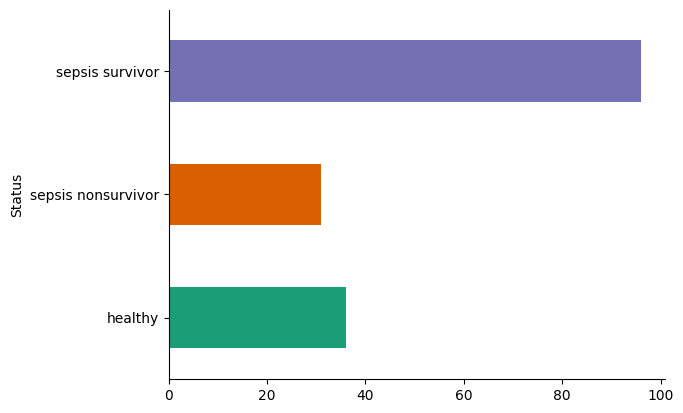

In [22]:
sample_info.groupby('Status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

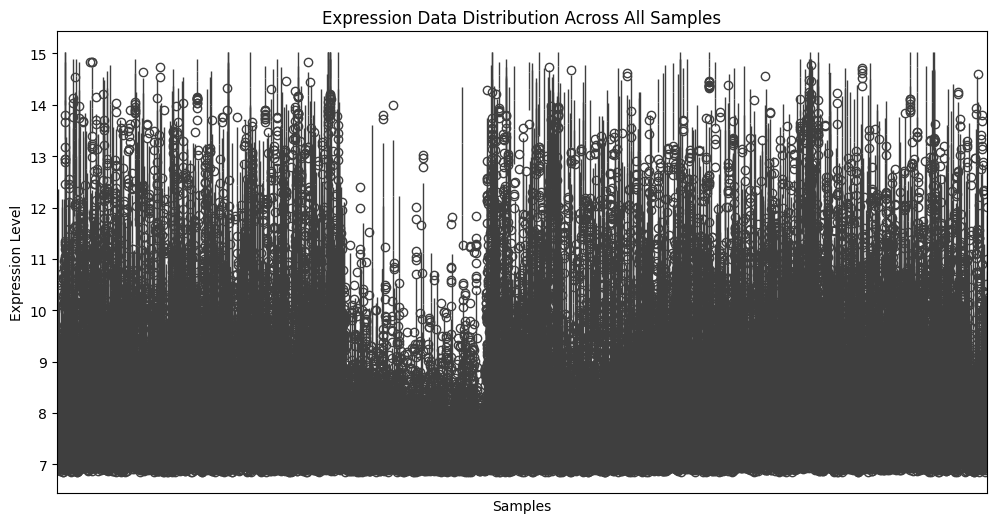

In [23]:
# Data Visualize
plt.figure(figsize=(12, 6))
sns.boxplot(data=expression_data)
plt.xticks([])
plt.title("Expression Data Distribution Across All Samples")
plt.xlabel("Samples")
plt.ylabel("Expression Level")
plt.show()

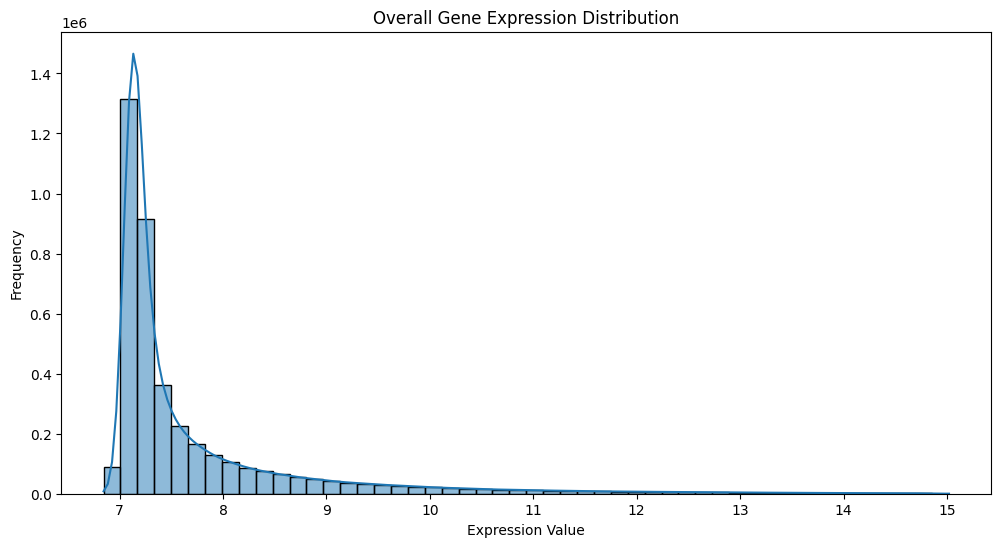

In [24]:
# Plot overall gene expression distribution
plt.figure(figsize=(12, 6))
sns.histplot(expression_data.values.flatten(), bins=50, kde=True)
plt.title('Overall Gene Expression Distribution')
plt.xlabel('Expression Value')
plt.ylabel('Frequency')
plt.show()

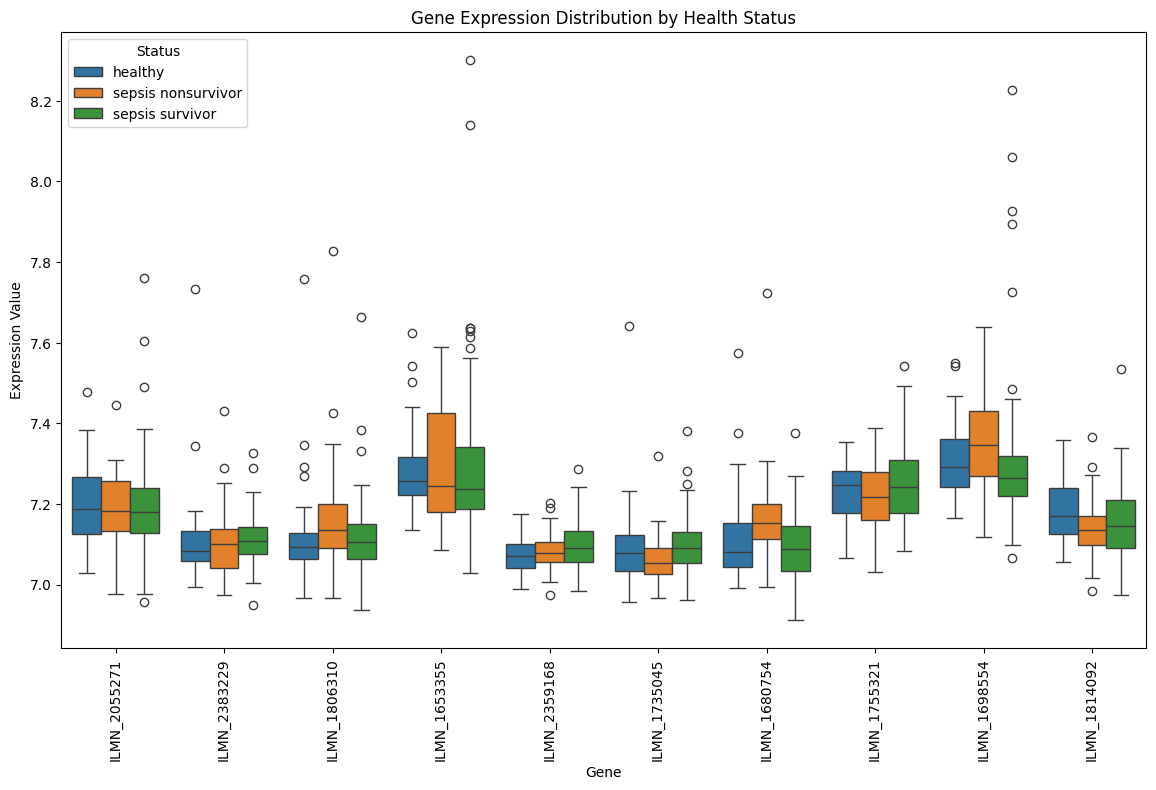

In [25]:
subset_genes = expression_data.columns[:10]
melted_data = pd.melt(expression_data[subset_genes].reset_index(), id_vars="index")
melted_data.columns = ["Sample", "Gene", "Expression"]
melted_data = melted_data.merge(sample_info, left_on="Sample", right_on="Sample")

plt.figure(figsize=(14, 8))
sns.boxplot(x='Gene', y='Expression', hue='Status', data=melted_data)
plt.title('Gene Expression Distribution by Health Status')
plt.xlabel('Gene')
plt.ylabel('Expression Value')
plt.xticks(rotation=90)
plt.show()

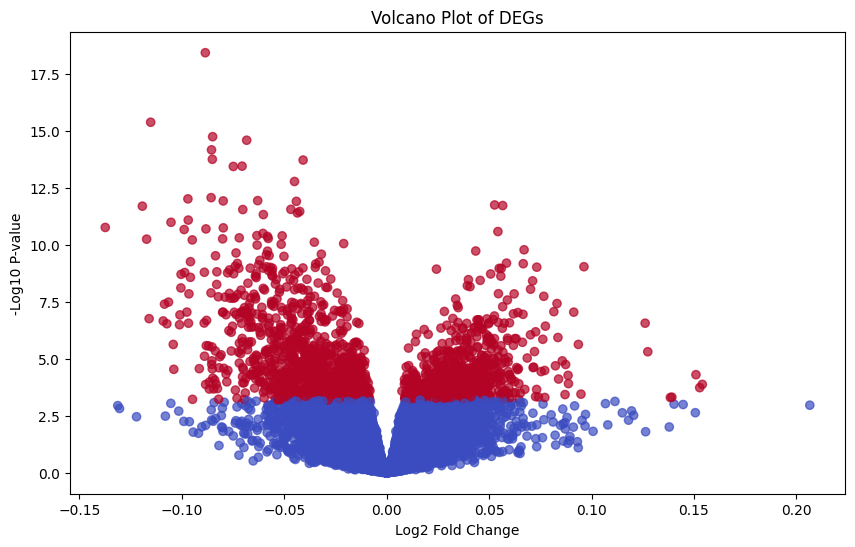

In [26]:
# Calculate log2 fold change
log_fold_changes = np.log2(expression_data.loc[group2].mean() / expression_data.loc[group1].mean())

# Volcano plot
plt.figure(figsize=(10, 6))
plt.scatter(log_fold_changes, -np.log10(p_values), c=(p_adjusted < 0.01), cmap="coolwarm", alpha=0.7)
plt.title("Volcano Plot of DEGs")
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 P-value")
plt.show()

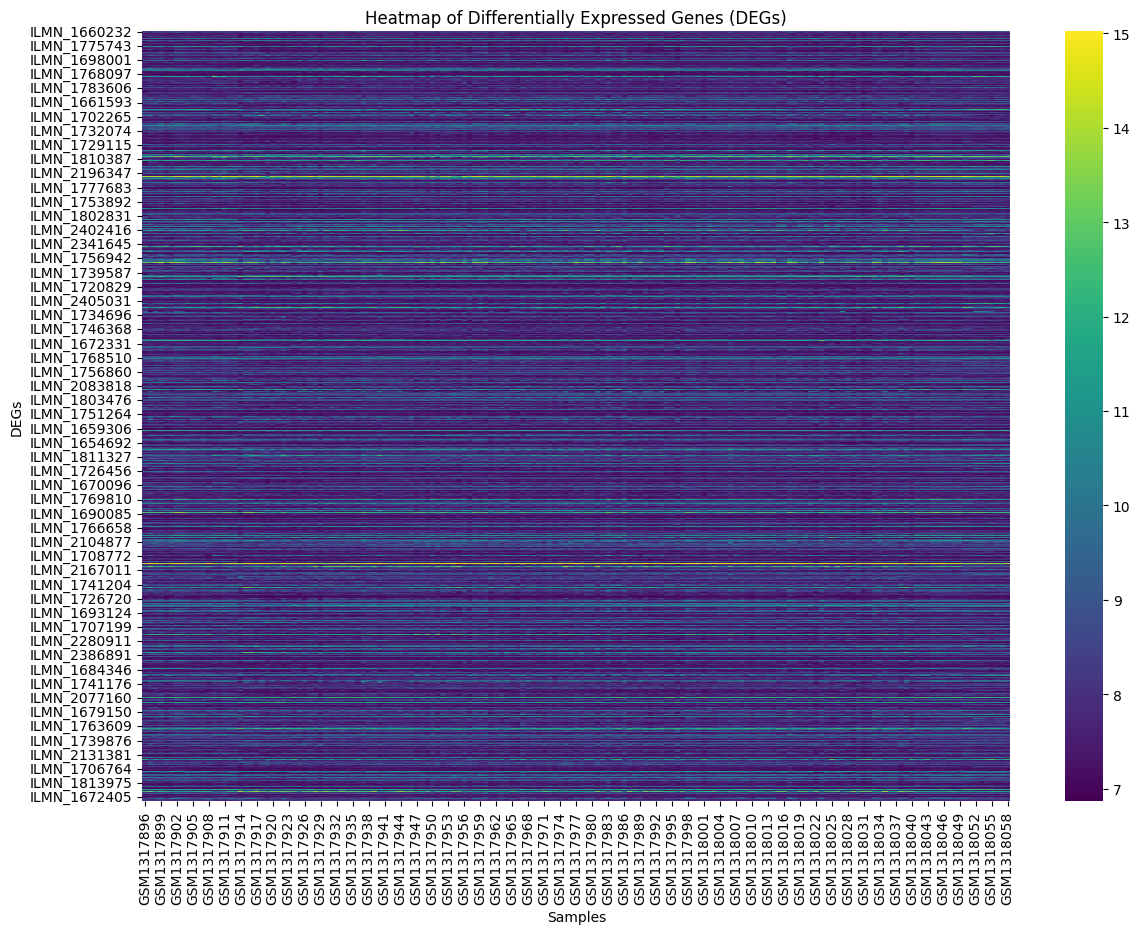

In [27]:
# Select DEGs expression data
degs_expression_data = expression_data[selected_probes]

# Heatmap of DEGs
plt.figure(figsize=(14, 10))
sns.heatmap(degs_expression_data.T, cmap="viridis", cbar=True)
plt.title("Heatmap of Differentially Expressed Genes (DEGs)")
plt.xlabel("Samples")
plt.ylabel("DEGs")
plt.show()

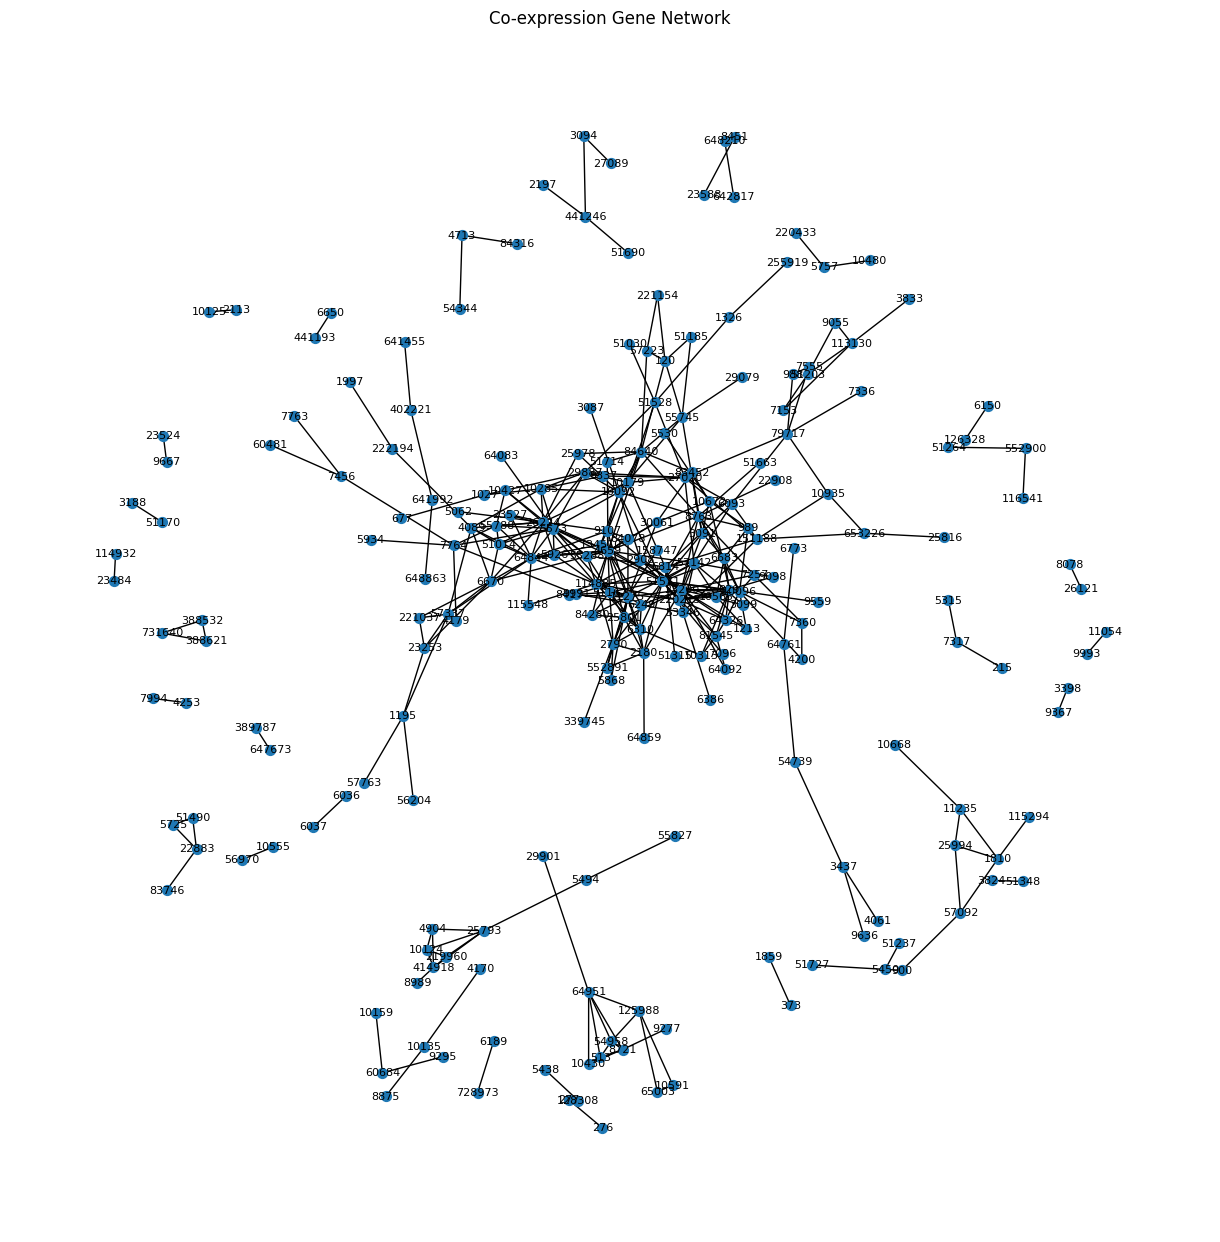

In [28]:
# Create a graph from co-expression edges
G = nx.Graph()
G.add_edges_from(co_expression_edges)

# Plot the co-expression network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15)
nx.draw(G, pos, with_labels=True, node_size=50, font_size=8)
plt.title("Co-expression Gene Network")
plt.show()

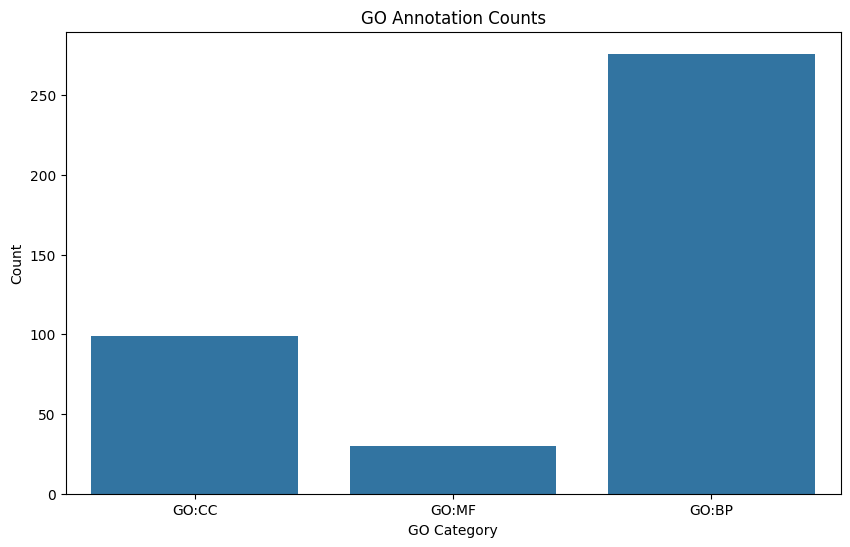

In [29]:
# Bar plot of GO annotation counts
plt.figure(figsize=(10, 6))
sns.barplot(x=go_stats.index, y='Count', data=go_stats)
plt.title("GO Annotation Counts")
plt.xlabel("GO Category")
plt.ylabel("Count")
plt.show()

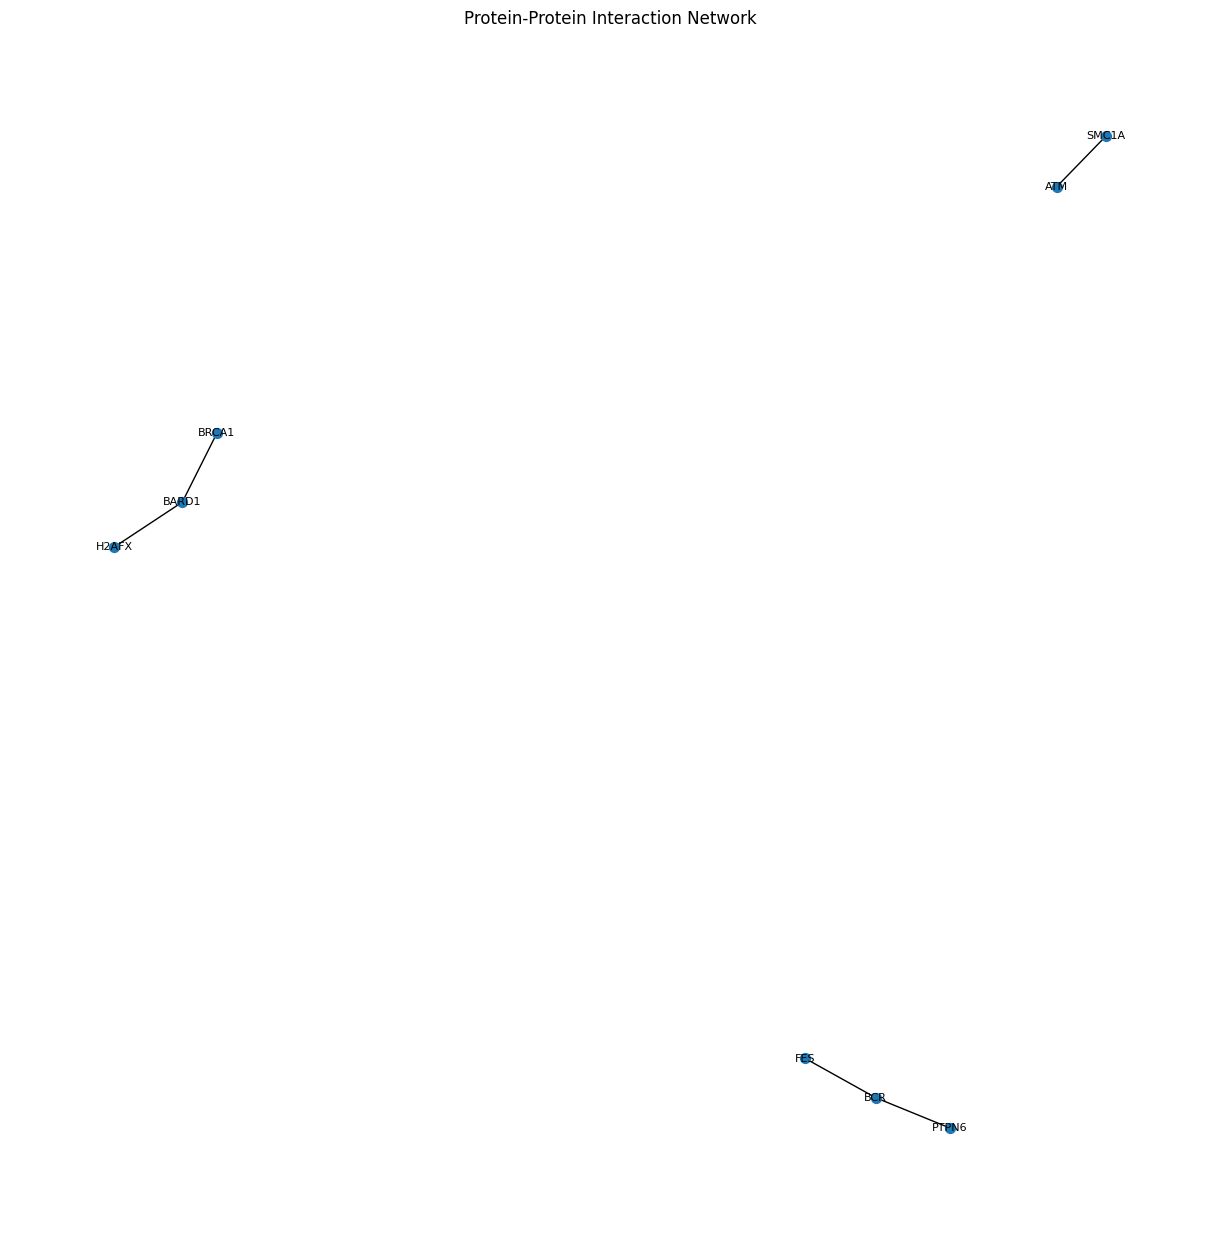

In [30]:
# Create a graph from BioGRID interactions
G_biogrid = nx.Graph()
for _, row in biogrid_interactions_summary.iterrows():
    G_biogrid.add_edge(row['Official Symbol Interactor A'], row['Official Symbol Interactor B'])

# Plot the protein-protein interaction network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_biogrid, k=0.15)
nx.draw(G_biogrid, pos, with_labels=True, node_size=50, font_size=8)
plt.title("Protein-Protein Interaction Network")
plt.show()

In [31]:
# Basic description of sample information
print("Sample Information Description:")
print(sample_info.describe())

Sample Information Description:
            Sample           Status
count          163              163
unique         163                3
top     GSM1317896  sepsis survivor
freq             1               96


## Pathways

In [32]:
def get_pathway_annotations(gene_symbols):
    '''Function to get pathway annotations
    @param list of entrez gene ID
    @return a dataframe with the pathway enrichment results
    '''
    gp = GProfiler(return_dataframe=True)
    pathway_results = gp.profile(
        organism='hsapiens',
        query=gene_symbols,
        no_evidences=False,
        sources=["REAC", "KEGG", "WP"]
    )
    return pathway_results

pathway_results = get_pathway_annotations(selected_genes)
print("Pathway analysis successfully retrieved")

top_pathways = pathway_results.sort_values(by='p_value').head(10)

Pathway analysis successfully retrieved


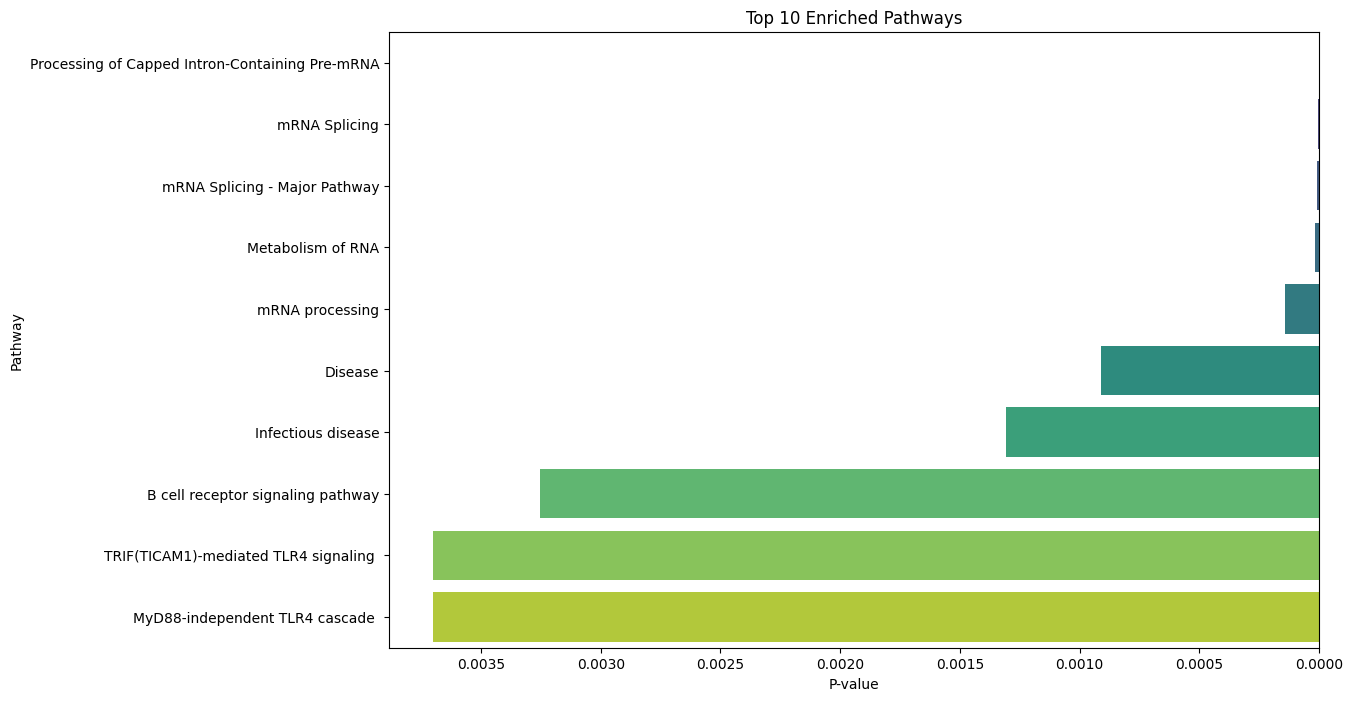

In [33]:
# Bar plot of top 10 pathways
plt.figure(figsize=(12, 8))
sns.barplot(x='p_value', y='name', data=top_pathways, palette='viridis')
plt.title('Top 10 Enriched Pathways')
plt.xlabel('P-value')
plt.ylabel('Pathway')
plt.gca().invert_xaxis()
plt.show()

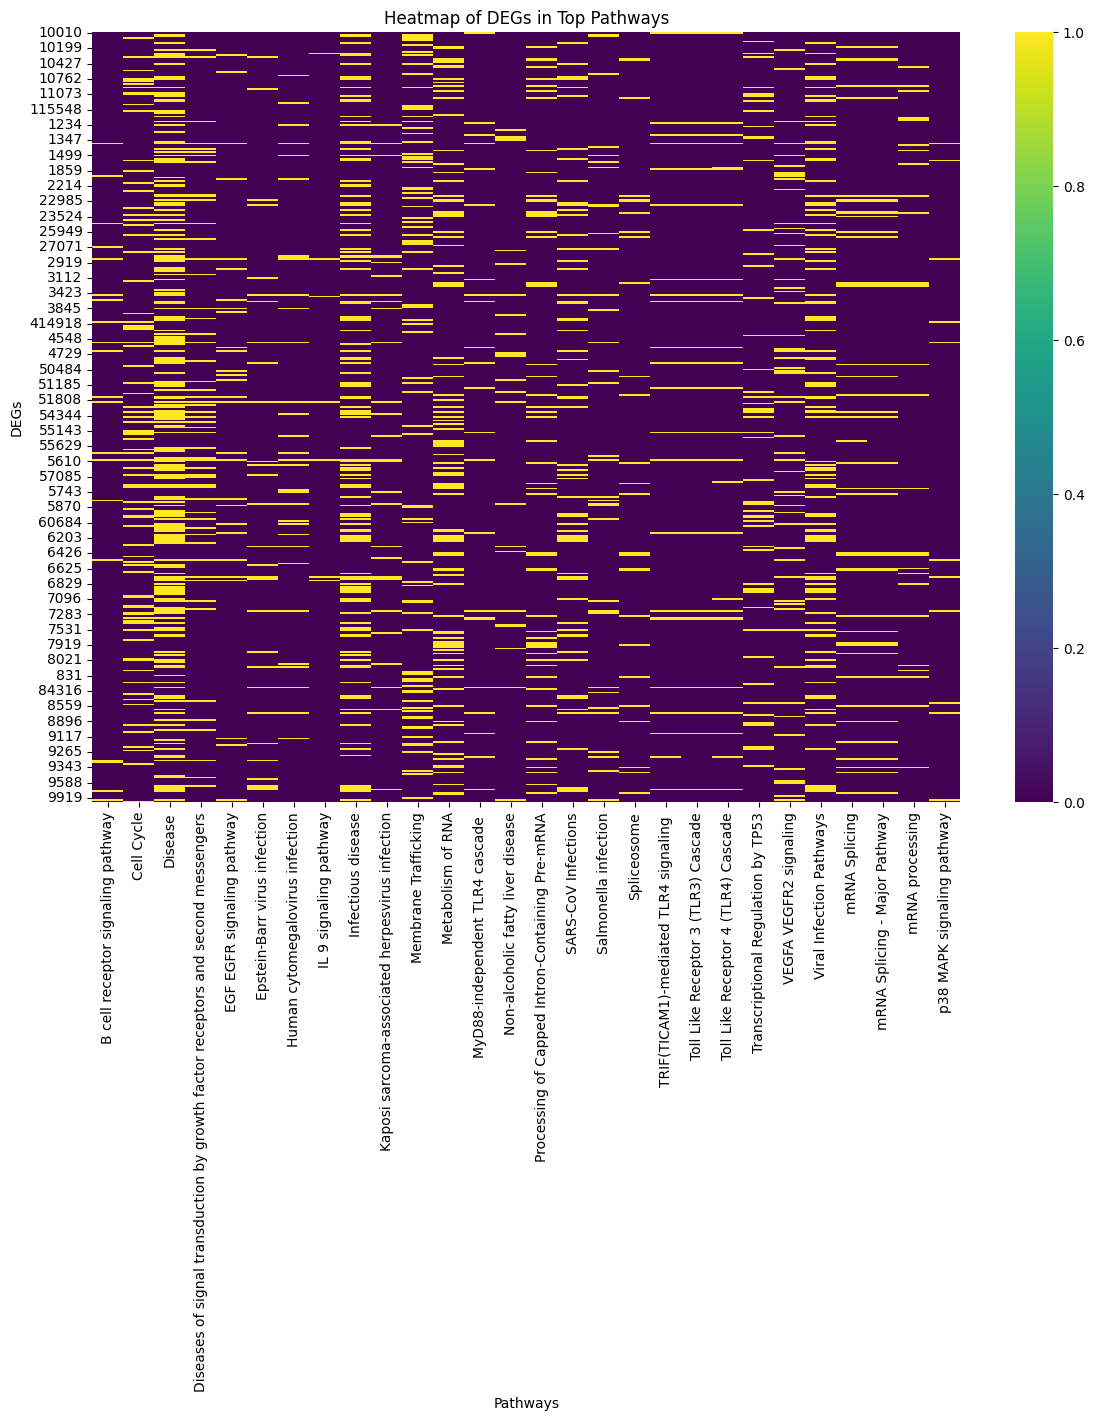

In [34]:
# Create a binary matrix for genes and pathways
pathway_genes = pathway_results.explode('intersections').pivot_table(
    index='intersections', columns='name', values='p_value', aggfunc='size', fill_value=0
)

# Heatmap of DEGs in pathways
plt.figure(figsize=(14, 10))
sns.heatmap(pathway_genes, cmap="viridis", cbar=True)
plt.title("Heatmap of DEGs in Top Pathways")
plt.xlabel("Pathways")
plt.ylabel("DEGs")
plt.xticks(rotation=90)
plt.show()